# AutoEncoder

### By: Huan Shuo Hsu

## Method Overview
What is AutoEncoder?
- A neural network that compresses data into a smaller latent representation and reconstructs it back.
- Trained on normal data so anomalies appear as large reconstruction errors.
- Good at handling high-dimensional features.

Implentation Steps:
1. We will be using the autoencoder function from PyOD on a healthcare dataset.
2. Specify the architecture (number of layers, neurons, activation functions).
3. Fir the model on training data (normal instances).
4. Get outlier labls and scores on test data.
5. Count of anomalies vs. normal cases.
6. Visualize the score distribution.



## Table of Contents
* [Section 1: Data Preparation](#1)
    * [Section 1.1: Libraries](#11)
    * [Section 1.2: Loading Data](#12)
    * [Section 1.3: Data Cleaning](#13)
* [Section 2: Single AutoEncoder Model](#2)
    * [Section 2.1: Importing & Fitting](#21)
    * [Section 2.2: Prediction & Scores](#22)
    * [Section 2.3: Interpreting the Outliers](#23)
        * [Section 2.3.1: Distribution of Anomaly Scores](#231)
        * [Section 2.3.2: Anomalies vs Normals in Feature Space](#232)
        * [Section 2.3.3: Reconstruction Error across Samples](#233)
        * [Section 2.3.4: Top 20 Highest Anomalies by Hospital](#234)
* [Section 4: Ensmeble AutoEncoder Model](#4)
    * [Section 4.1: Distribution of features](#41)
    * [Section 4.2: Importing & Fitting](#42)
    * [Section 4.3: Prediction & Scoring](#43)
* [Section 4: What's Next?](#5)


# Data Preperation <a name="1"></a>

## Libraries <a name="11"></a>

In [199]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import tensorflow as tf
from pyod.models.auto_encoder import AutoEncoder
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import median_abs_deviation
from scipy.spatial.distance import mahalanobis
from pyod.models.combination import aom, moa, average, maximization

## Loading Data <a name="12"></a>

In [58]:
df = pd.read_csv('data/inpatientCharges.csv')

# Overview
print("Shape of dataset:", df.shape)

# Checking for missing value
missing_values = df.isnull().sum()

print("Missing values:", missing_values[missing_values > 0])
df.head()

Shape of dataset: (163065, 12)
Missing values: Series([], dtype: int64)


,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


## Data Cleaning <a name="13"></a>
- We will not be considering catagorical features like "Hospital Name" as it will add uncessary dimensions to the data.
- Identifiers like Provider ID, Zip Code will also be excluded since they are not meaningful features.
- We will also standardize the data since neural networks are sensitive to feature scales.

In [59]:
# Convert $ columns to numeric 
df.columns = df.columns.str.strip()
money_cols = ["Average Covered Charges", "Average Total Payments", "Average Medicare Payments"]
for col in money_cols:
    df[col] = df[col].str.replace("$", "", regex=False).astype(float)

# Select only numeric columns we want
numeric_cols = ["Total Discharges"] + money_cols
X = df[numeric_cols]

df[numeric_cols].head(10)

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,91,32963.07,5777.24,4763.73
1,14,15131.85,5787.57,4976.71
2,24,37560.37,5434.95,4453.79
3,25,13998.28,5417.56,4129.16
4,18,31633.27,5658.33,4851.44
5,67,16920.79,6653.80,5374.14
6,51,11977.13,5834.74,4761.41
7,32,35841.09,8031.12,5858.50
8,135,28523.39,6113.38,5228.40
9,34,75233.38,5541.05,4386.94


In [ ]:
# Scale features (neural networks only accept scaled data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easy inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols)
X_scaled_df.head()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,0.943640,-0.090428,-0.512776,-0.510403
1,-0.563094,-0.598943,-0.511428,-0.481265
2,-0.367414,0.040679,-0.557435,-0.552805
3,-0.347846,-0.631271,-0.559703,-0.597218
4,-0.484822,-0.128352,-0.528290,-0.498403


# Single AutoEncoder Model <a name="2"></a>

## Importing & Fitting <a name="21"></a>
- We specify the architecture: compress 4 input features > bottleneck of 2 > reconstruct back to 4.

- ReLU is used in hidden layers to capture non-linear relationships.

- Sigmoid is used at the output to squash values between 0 and 1 for reconstruction.

- An epoch is one full pass through the dataset.
    - 30 is a balanced choice: enough iterations for the model to converge without overfitting on such a small dataset.

- A batch size of 32 is common for small to medium datasets, balancing memory efficiency and convergence speed.

- Contamination is set to 0.05 assuming ~5% anomalies in the data for thresholding.

- Random state ensures reproducibility of results. The value “42” is arbitrary but commonly used in data science as a reproducible seed.

In [ ]:
# Build AutoEncoder model
clf = AutoEncoder(hidden_neurons=[4, 2, 2, 4],    # encoder/decoder layers
                  hidden_activation='relu',
                  output_activation='sigmoid',
                  epochs=30, 
                  batch_size=32,
                  contamination=0.05,   # ~5% anomalies for decision thresholding
                  random_state=42)

# Fit the model
clf.fit(X_scaled_df)

c:\Users\User\miniconda3\envs\anomaly_detection\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108 (432.00 B)

 Trainable params: 108 (432.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 5s 761us/step - loss: 2.1456 - val_loss: 1.0741
Epoch 2/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 3s 752us/step - loss: 1.0338 - val_loss: 0.9942
Epoch 3/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 762us/step - loss: 1.0048 - val_loss: 0.9872
Epoch 4/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 3s 742us/step - loss: 1.0019 - val_loss: 0.9864
Epoch 5/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 884us/step - loss: 1.0016 - val_loss: 0.9863
Epoch 6/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 861us/step - loss: 1.0016 - val_loss: 0.9863
Epoch 7/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 852us/step - loss: 1.0015 - val_loss: 0.9863
Epoch 8/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 862us/step - loss: 1.0015 - val_loss: 0.9863
Epoch 9/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 845us/step - loss: 1.0015 - val_loss: 0.9863
Epoch 10/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 828us/step - loss: 1.0015 - val_loss: 0.9863
Epoch 11/30
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 846us/step - loss: 1.0015 - val_loss: 0.9863
Epo

AutoEncoder(batch_size=32, contamination=0.05, dropout_rate=0.2, epochs=30,
      hidden_activation='relu', hidden_neurons=[4, 2, 2, 4],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x00000200A22868E0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=42, validation_size=0.1, verbose=1)

## Prediction & Scores <a name="22"></a>

In [191]:
# Get predictions (1 = outlier, 0 = inlier)
y_pred = clf.labels_

# Get anomaly scores
y_scores = clf.decision_scores_

# Add results back to DataFrame
results = X_scaled_df.copy()
results["Anomaly_Label"] = y_pred
results["Anomaly_Score"] = y_scores

results.head(10)


,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Anomaly_Label,Anomaly_Score
0,0.943640,-0.090428,-0.512776,-0.510403,0,2.041457
1,-0.563094,-0.598943,-0.511428,-0.481265,0,1.558815
2,-0.367414,0.040679,-0.557435,-0.552805,0,2.459442
3,-0.347846,-0.631271,-0.559703,-0.597218,0,2.087890
4,-0.484822,-0.128352,-0.528290,-0.498403,0,1.689787
5,0.474009,-0.547926,-0.398412,-0.426893,0,2.567222
6,0.160921,-0.688910,-0.505274,-0.510720,0,1.795684
7,-0.210871,-0.008352,-0.218713,-0.360628,0,4.723578
8,1.804632,-0.217040,-0.468920,-0.446832,0,2.736973
9,-0.171735,1.115047,-0.543592,-0.561951,0,5.474779


### What the table shows:
Anomaly_Label = model’s prediction:
- 0 → inlier (normal point)

- 1 → outlier (anomaly)

Anomaly_Score = how “anomalous” the model thinks the row is.
- Higher score = more likely anomaly.

- The cutoff between 0 and 1 depends on our chosen contamination=0.05.

Why most rows will have label = 0?
- The dataset has 163,065 rows, only about ~8,150 will get Anomaly_Label = 1 since the model assumes only ~5% of points are anomalies.

In [67]:
# Count anomalies
outlier_count = (y_pred == 1).sum()
total_count = len(y_pred)
outlier_pct = (outlier_count / total_count) * 100

print(f"Anomalies detected: {outlier_count} out of {total_count} rows")
print(f"Percentage of anomalies: {outlier_pct:.2f}%")

Anomalies detected: 8154 out of 163065 rows
Percentage of anomalies: 5.00%


# Interpreting the Outliers <a name="23"></a>
We will be merging with the original healthcare dataset and the model’s anomaly predictions to show the first 10 hospitals that the AutoEncoder thinks are outliers.

In [80]:
df_with_outliers = df.copy()
df_with_outliers["Anomaly_Label"] = y_pred
df_with_outliers["Anomaly_Score"] = y_scores

# Show only anomalies
df_with_outliers[df_with_outliers["Anomaly_Label"] == 1].head(10)


,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Anomaly_Label,Anomaly_Score
1191,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,STANFORD,CA,94305,CA - San Mateo County,16,148128.43,25519.43,22553.56,1,4.292980
2397,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50103,WHITE MEMORIAL MEDICAL CENTER,1720 E CESAR AVENUE,LOS ANGELES,CA,90033,CA - Los Angeles,46,149950.26,21903.73,21121.19,1,4.006801
2405,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50125,REGIONAL MEDICAL CENTER OF SAN JOSE,225 N JACKSON AVENUE,SAN JOSE,CA,95116,CA - San Jose,46,161240.45,21440.43,20587.47,1,4.220500
2419,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50179,EMANUEL MEDICAL CENTER INC,825 DELBON AVE,TURLOCK,CA,95382,CA - Modesto,12,192817.91,21166.08,20325.00,1,5.018202
2420,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50180,JOHN MUIR MEDICAL CENTER - WALNUT CREEK CAMPUS,1601 YGNACIO VALLEY RD,WALNUT CREEK,CA,94598,CA - Contra Costa County,72,162975.59,24440.79,21227.30,1,4.487762
2422,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50195,WASHINGTON HOSPITAL,2000 MOWRY AVE,FREMONT,CA,94538,CA - Alameda County,50,170174.32,22851.80,22046.34,1,4.583593
2428,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50228,SAN FRANCISCO GENERAL HOSPITAL,1001 POTRERO AVENUE,SAN FRANCISCO,CA,94110,CA - San Francisco,19,158080.21,35275.57,34455.00,1,6.004257
2431,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50235,PROVIDENCE SAINT JOSEPH MEDICAL CTR,501 SOUTH BUENA VISTA,BURBANK,CA,91505,CA - Los Angeles,117,155499.94,16567.40,15814.95,1,3.937050
2433,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50239,GLENDALE ADVENTIST MEDICAL CENTER,1509 E WILSON TERRACE,GLENDALE,CA,91206,CA - Los Angeles,62,165409.72,25240.79,20987.33,1,4.556359
2441,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50278,PROVIDENCE HOLY CROSS MEDICAL CENTER,15031 RINALDI ST,MISSION HILLS,CA,91346,CA - Los Angeles,36,169408.61,17659.88,16723.63,1,4.099560


- The AutoEncoder flagged hospitals with unusually high covered charges and mismatched payments for the same DRG.

- All of these rows are for neurological conditions, yet one hospital charges $148k, another $192k, another $158k. Patients with the same condition are being billed wildly different amounts depending on the hospital.

- Emanuel Medical Center had only 12 discharges yet billed at $192k each. Providence Saint Joseph had 117 discharges but charges ~$155k each. This suggest that billing anomalies may not be tied to patient volume.

## Distribution of Anomaly Scores <a name="231"></a>

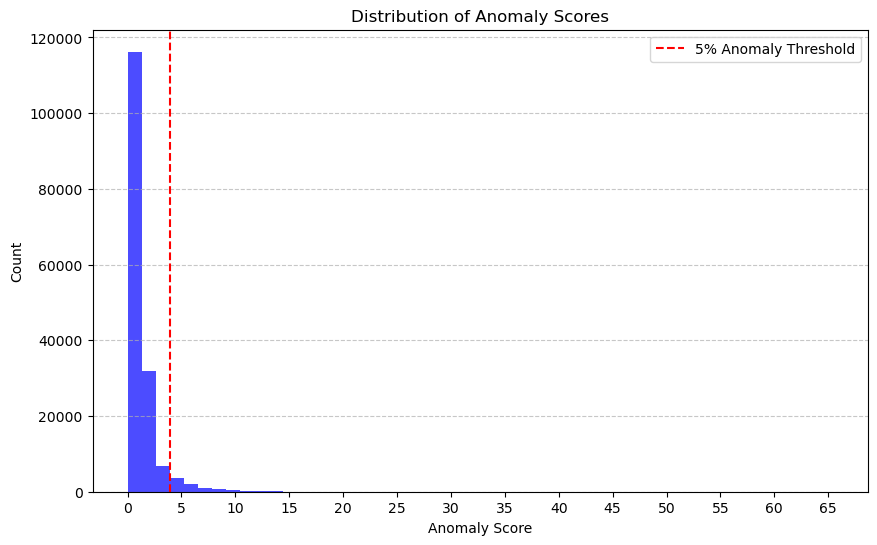

In [151]:
plt.figure(figsize=(10,6))
plt.hist(df_with_outliers["Anomaly_Score"], bins=50, alpha=0.7, color="blue")
plt.axvline(df_with_outliers[df_with_outliers["Anomaly_Label"]==1]["Anomaly_Score"].min(),
            color="red", linestyle="--", label="5% Anomaly Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.title("Distribution of Anomaly Scores")
plt.legend()
plt.grid(axis="y", linestyle ="--", alpha=0.7)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
plt.show()

- Everything left of the line → predicted normal (0).

- Everything right of the line → predicted anomaly (1).

- Because the line is set by your chosen contamination rate, it’s not arbitrary in the plot—it’s the score value where the highest ~5% begin.

- A visible right tail means the model sees a small subset of cases that don’t fit the majority pattern learned from the 4 features.(Total Discharges, Avg Covered Charges, Avg Total Payments, Avg Medicare Payments).

- We can also see the the largest score stretches above 65, indicating some cases are quite different from the norm. This means that there will be several hospitals/records that the model considers highly anomalous and will require further investigation.

## Anomalies vs Normals in Feature Space <a name="232"></a>

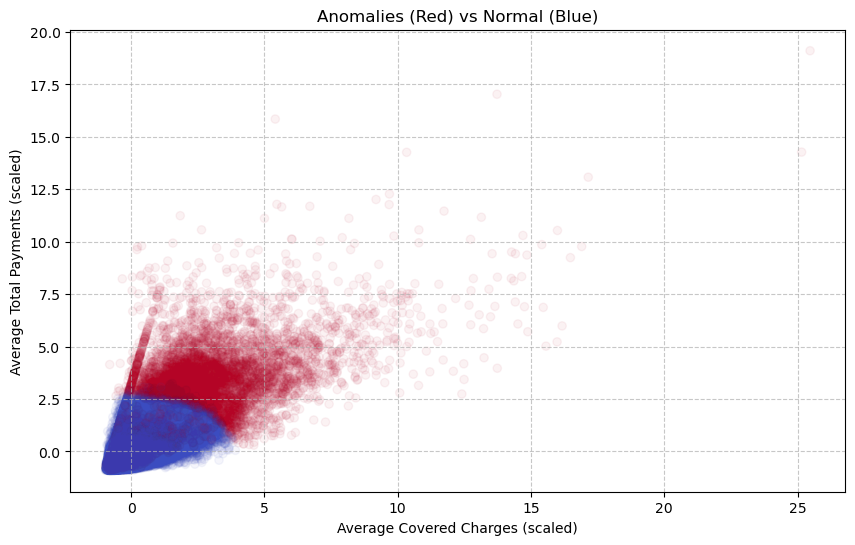

In [154]:
plt.figure(figsize=(10,6))
plt.scatter(X_scaled_df["Average Covered Charges"], 
            X_scaled_df["Average Total Payments"], 
            c=df_with_outliers["Anomaly_Label"], cmap="coolwarm", alpha=0.05)

plt.xlabel("Average Covered Charges (scaled)")
plt.ylabel("Average Total Payments (scaled)")
plt.title("Anomalies (Red) vs Normal (Blue)")
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.show()


- Normals (blue): tightly clustered near the lower left, meaning most hospitals have relatively low-to-moderate charges and payments that follow the expected relationship.

- Anomalies (red): spread widely across the plot, especially in the upper-right, which corresponds to higher charges and higher payments. Some anomalies also appear scattered at unusual positions outside the dense blue cluster.

- The AutoEncoder has learned that “normal” hospitals have a certain proportionality between charges and payments.

- Hospitals that deviate (for example, very high charges but disproportionately high or low payments) get flagged as anomalies.

- The model confirms that most hospitals maintain a proportional charges-to-payments relationship.

## Reconstruction Error across Samples <a name="233"></a>

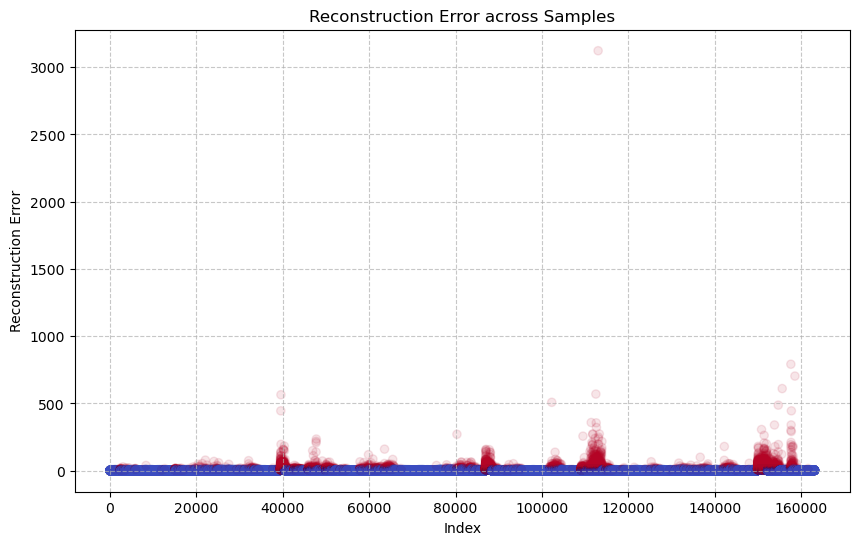

In [155]:
reconstruction_error = ((X_scaled_df - clf.decision_scores_.reshape(-1,1))**2).mean(axis=1)

plt.figure(figsize=(10,6))
plt.scatter(range(len(reconstruction_error)), reconstruction_error,
            c=df_with_outliers["Anomaly_Label"], cmap="coolwarm", alpha=0.1)
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error across Samples")
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.show()


- This plot ranks every hospital visit (x-axis = sample index) by how well the autoencoder can reconstruct its inputs. The y-axis is the reconstruction error:
    - Low error > the autoencoder easily learns and reproduces the hospital’s features (normal).
    - High error > the autoencoder struggles to reproduce the features (anomalous).

- The majority of hospitals (blue) cluster tightly around low error values.

- Certain hospitals show extremely high reconstruction errors (red), indicating they have feature patterns that the autoencoder cannot effectively learn. These are the anomalies.

- This means that hospitals with high reconstruction error do not follow the typical charge-to-payment structure learned from the rest and will require further investigation.

## Top 20 Highest Anomalies by Hospital <a name="234"></a>

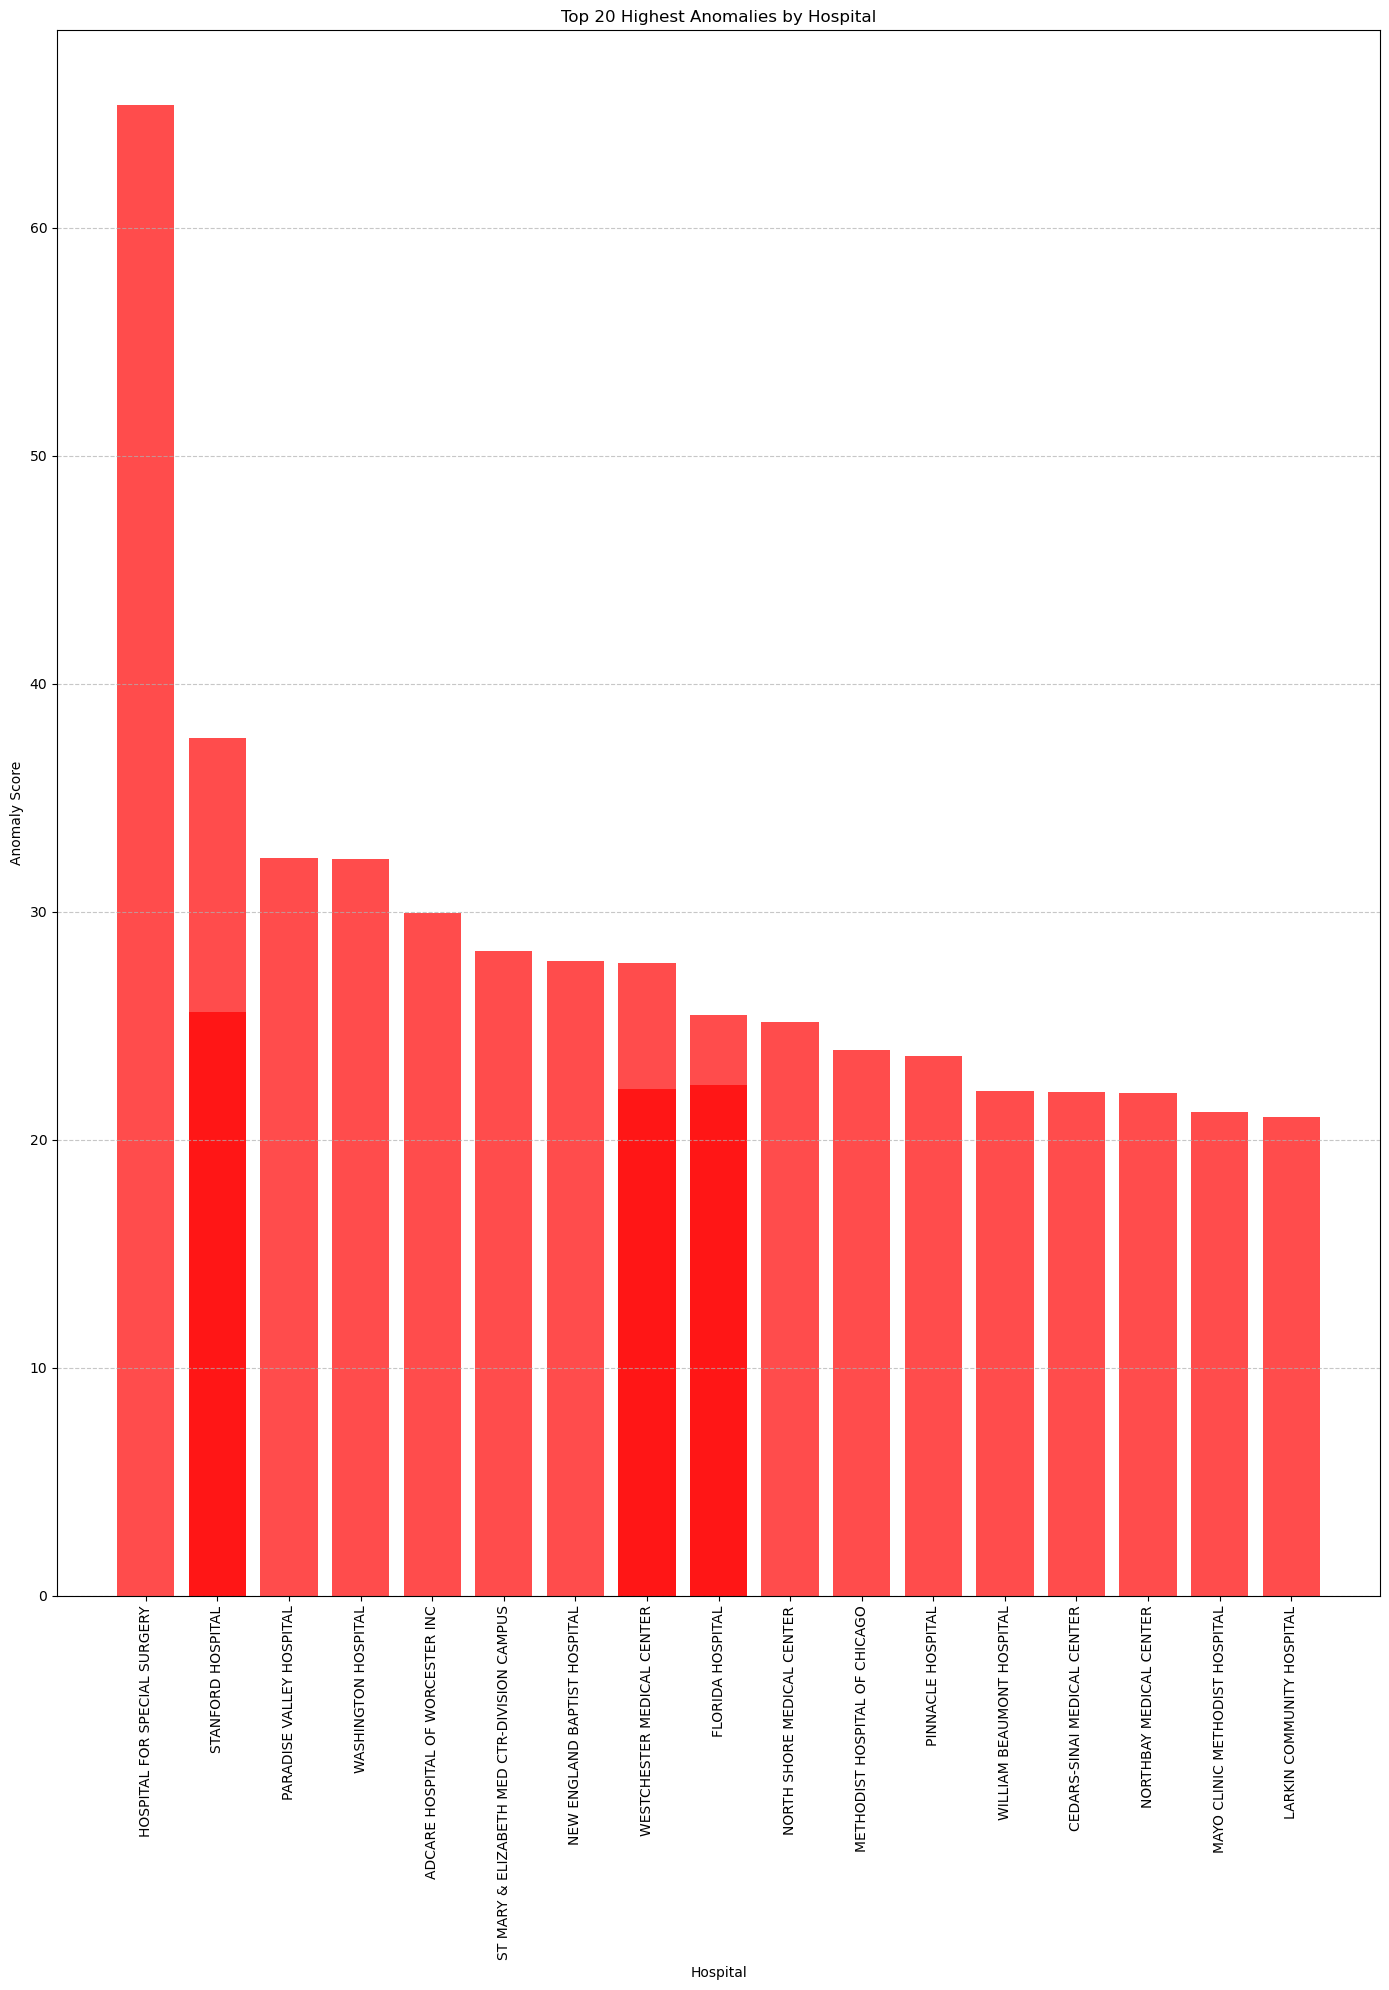

In [ ]:
top_anomalies = df_with_outliers[df_with_outliers["Anomaly_Label"] == 1] \
                    .sort_values("Anomaly_Score", ascending=False).head(20)

plt.figure(figsize=(14,20))
plt.bar(top_anomalies["Provider Name"], top_anomalies["Anomaly_Score"], 
        color="red", alpha=0.7)

plt.xticks(rotation=90)
plt.xlabel("Hospital")
plt.ylabel("Anomaly Score")
plt.title("Top 20 Highest Anomalies by Hospital")
plt.tight_layout()
plt.grid(axis="y", linestyle ="--", alpha=0.7)
plt.show()


- This bar chart ranks the 20 hospitals with the highest anomaly scores. The x-axis lists hospital names, and the y-axis shows their anomaly scores.

- Hospitals at the far left with the tallest bars are the most unusual relative to all others.

- For decision makers (health admins or government), this is the “shortlist” of hospitals that stand out most.

- Instead of investigating all 163,000 rows, this chart reduces the workload to a targeted set of top outliers.

# Ensemble Autoencoder Model <a name="4"></a>

Instead of training a single AutoEncoder on all features, we will train multiple AutoEncoders on different feature subsets and combine their anomaly scores into an ensemble score.

We can pull in the engineered features such as:

- Feat_Ratio_StateDRG

- Feat_Deviation_StateDRG

- RZ_Average_Total_Payments_by_Provider_State_DRG

- Feat_MedicareShare

- Feat_Markup

- Feat_DollarImpact

- MD_Average_Covered_Charges_Average_Total_Payments_Average_Medicare_Payment_by_Provider_State_DRG


In [161]:
# ----------------------------
# Load + basic cleaning
# ----------------------------
data = pd.read_csv("data/inpatientCharges.csv")

# Clean column names
data.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']

# Convert to numeric
money_cols = ['Average_Covered_Charges','Average_Total_Payments','Average_Medicare_Payment']
for c in money_cols:
    data[c] = data[c].astype(str).str.replace('$','').astype(float)

data['Total_Payments_Est'] = data['Average_Total_Payments'] * data['Total_Discharges']
data['Total_Medicare_Est'] = data['Average_Medicare_Payment'] * data['Total_Discharges']
data['Total_Covered_Est']  = data['Average_Covered_Charges'] * data['Total_Discharges']

# ----------------------------
# Helper functions
# ----------------------------
def robust_z_by_group(df, value_col, by_cols):
    def _rz(x):
        med = np.median(x)
        mad = median_abs_deviation(x, scale='normal')
        return (x - med) / (mad if mad != 0 else 1e-9)
    name = f'RZ_{value_col}_by_{"_".join(by_cols)}'
    df[name] = df.groupby(by_cols)[value_col].transform(_rz)
    return name

def pct_rank_by_group(df, value_col, by_cols):
    name = f'PctRank_{value_col}_by_{"_".join(by_cols)}'
    df[name] = df.groupby(by_cols)[value_col].rank(pct=True)
    return name

def ratio_to_p99_by_group(df, value_col, by_cols):
    name = f'RatioToP99_{value_col}_by_{"_".join(by_cols)}'
    p99 = df.groupby(by_cols)[value_col].transform(lambda x: np.percentile(x, 99))
    df[name] = df[value_col] / p99.replace(0, np.nan)
    return name

def iqr_outlier_score_by_group(df, value_col, by_cols):
    name = f'IQRScore_{value_col}_by_{"_".join(by_cols)}'
    def _score(x):
        q1, q3 = np.percentile(x, [25, 75])
        iqr = max(q3 - q1, 1e-9)
        return (x - q3) / iqr
    df[name] = df.groupby(by_cols)[value_col].transform(_score)
    return name

def mahalanobis_by_group(df, cols, by_cols):
    name = f'MD_{"_".join(cols)}_by_{"_".join(by_cols)}'
    df[name] = np.nan
    for keys, group in df.groupby(by_cols):
        X = group[cols].values
        if len(group) < len(cols) + 1:
            continue
        mu = X.mean(axis=0)
        cov = np.cov(X, rowvar=False)
        try:
            cov_inv = np.linalg.inv(cov)
        except np.linalg.LinAlgError:
            cov_inv = np.linalg.pinv(cov)
        d = np.array([mahalanobis(x, mu, cov_inv) for x in X])
        df.loc[group.index, name] = d
    return name

# ----------------------------
# Feature Engineering
# ----------------------------

# Benchmark: State×DRG averages
benchmark = data.groupby(['Provider_State','DRG'])['Average_Total_Payments'].mean().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Payment_ByStateDRG']
data = data.merge(benchmark, on=['Provider_State','DRG'], how='left')

data['Feat_Ratio_StateDRG']    = data['Average_Total_Payments'] / data['Avg_Payment_ByStateDRG'].replace(0, np.nan)
data['Feat_Deviation_StateDRG'] = data['Average_Total_Payments'] - data['Avg_Payment_ByStateDRG']

# Ratio to DRG 99th percentile
ratio_to_p99_by_group(data, 'Average_Total_Payments', ['DRG'])

# Robust Z-scores
robust_z_by_group(data, 'Average_Total_Payments', ['Provider_State','DRG'])

# Percentile rank
pct_rank_by_group(data, 'Average_Total_Payments', ['Provider_State','DRG'])

# Spend leverage
data['Feat_Spend_Leverage'] = data['Average_Total_Payments'] * np.log1p(data['Total_Discharges'])

# Medicare share
data['Feat_MedicareShare'] = data['Average_Medicare_Payment'] / data['Average_Total_Payments'].replace(0, np.nan)

# Markup
data['Feat_Markup'] = data['Average_Covered_Charges'] / data['Average_Total_Payments'].replace(0, np.nan)

# Payment share within State×DRG
grp = data.groupby(['Provider_State','DRG'])['Total_Payments_Est'].transform('sum').replace(0, np.nan)
data['Feat_PaymentShare_StateDRG'] = data['Total_Payments_Est'] / grp

# Case-mix adjusted index
drg_medians = data.groupby('DRG')['Average_Total_Payments'].median().reset_index()
drg_medians.rename(columns={'Average_Total_Payments': 'DRG_Median_Payment'}, inplace=True)
tmp = data.merge(drg_medians, on='DRG', how='left')
tmp['Feat_Ratio_vs_DRG_Median'] = tmp['Average_Total_Payments'] / tmp['DRG_Median_Payment']
hospital_index = tmp.groupby('Provider_Name')['Feat_Ratio_vs_DRG_Median'].mean().reset_index()
hospital_index.rename(columns={'Feat_Ratio_vs_DRG_Median':'Feat_CaseMix_Adjusted_Index'}, inplace=True)
data = data.merge(hospital_index, on='Provider_Name', how='left')

# IQR outlier score
iqr_outlier_score_by_group(data, 'Average_Total_Payments', ['DRG'])

# Provider mean residual
prov_resid = (data
    .assign(Resid=data['Average_Total_Payments'] - data['Avg_Payment_ByStateDRG'])
    .groupby('Provider_Name')['Resid'].mean()
    .reset_index(name='Feat_ProviderMeanResid'))
data = data.merge(prov_resid, on='Provider_Name', how='left')

# Dollar impact
data['Feat_DollarImpact'] = (data['Average_Total_Payments'] - data['Avg_Payment_ByStateDRG']) * data['Total_Discharges']

# Mahalanobis distance
mahalanobis_by_group(
    data,
    cols=['Average_Covered_Charges','Average_Total_Payments','Average_Medicare_Payment'],
    by_cols=['Provider_State','DRG']
)

# Divergence composite (markup vs Medicare share)
rz_markup = robust_z_by_group(data, 'Feat_Markup', ['Provider_State','DRG'])
rz_mshare = robust_z_by_group(data, 'Feat_MedicareShare', ['Provider_State','DRG'])
data['Feat_Divergence_Composite'] = data[rz_markup].fillna(0) - data[rz_mshare].fillna(0)

# ----------------------------
# Final feature set for autoencoder
# ----------------------------
feature_cols = [
    'Feat_Ratio_StateDRG','Feat_Deviation_StateDRG',
    'RZ_Average_Total_Payments_by_Provider_State_DRG',
    'PctRank_Average_Total_Payments_by_Provider_State_DRG',
    'Feat_Spend_Leverage','Feat_MedicareShare',
    'Feat_Markup','Feat_PaymentShare_StateDRG',
    'Feat_CaseMix_Adjusted_Index','IQRScore_Average_Total_Payments_by_DRG',
    'Feat_ProviderMeanResid','Feat_DollarImpact',
    'Feat_Divergence_Composite'
]
X = data[feature_cols].dropna()


## Distribution plots for each feature <a name="41"></a>

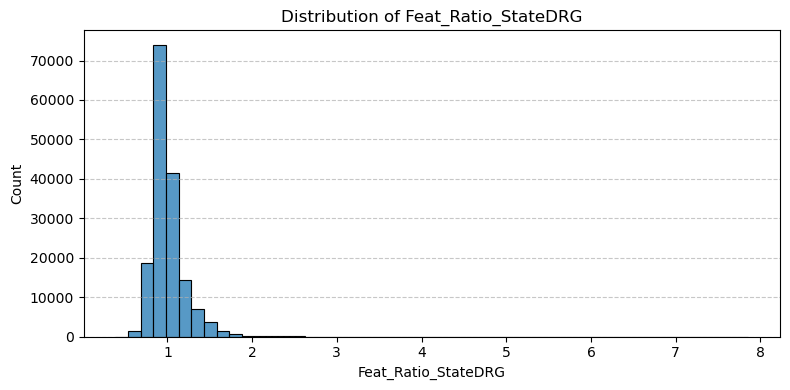

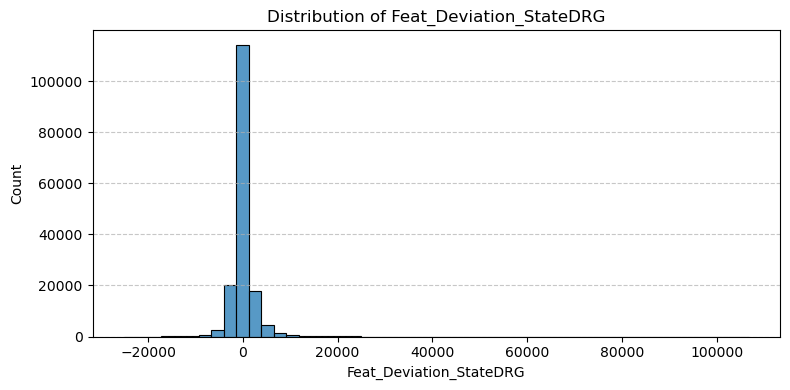

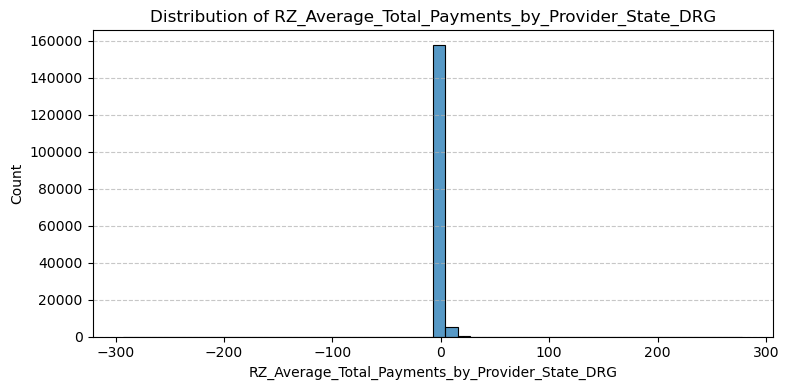

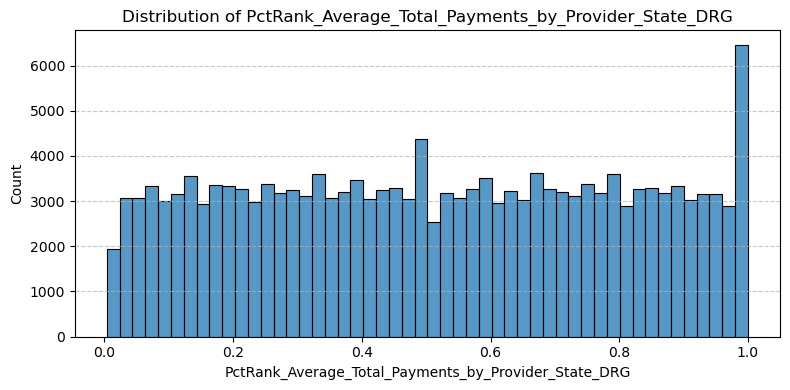

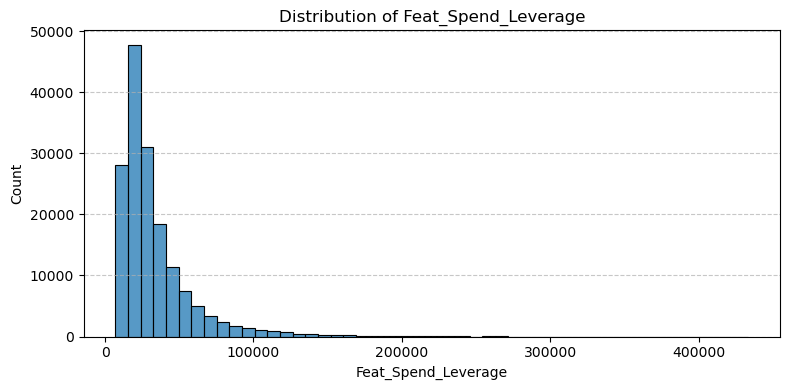

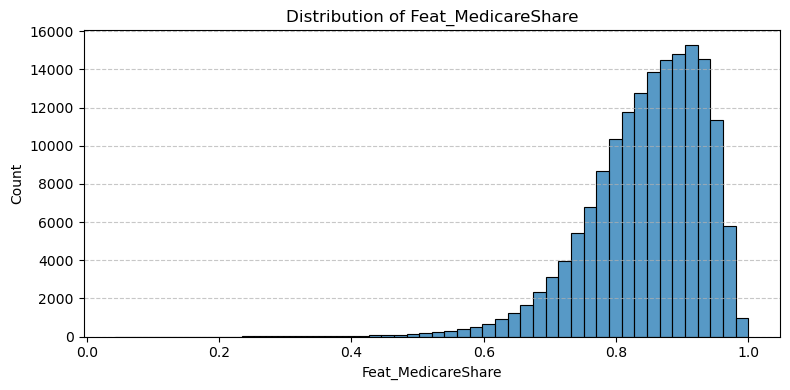

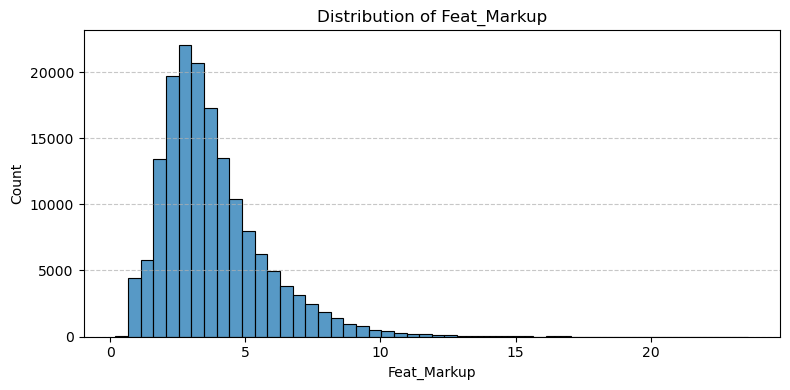

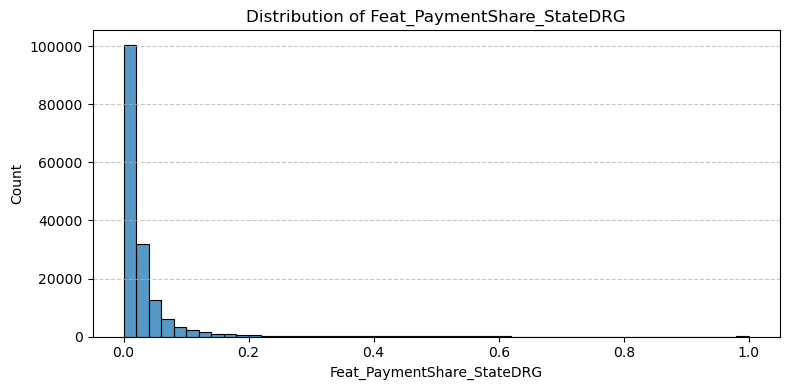

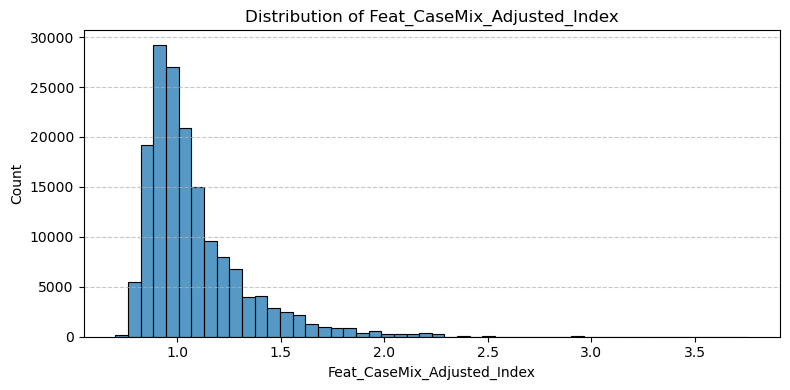

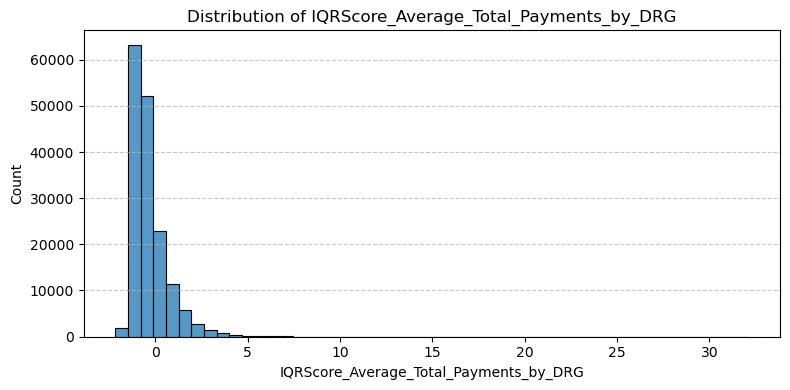

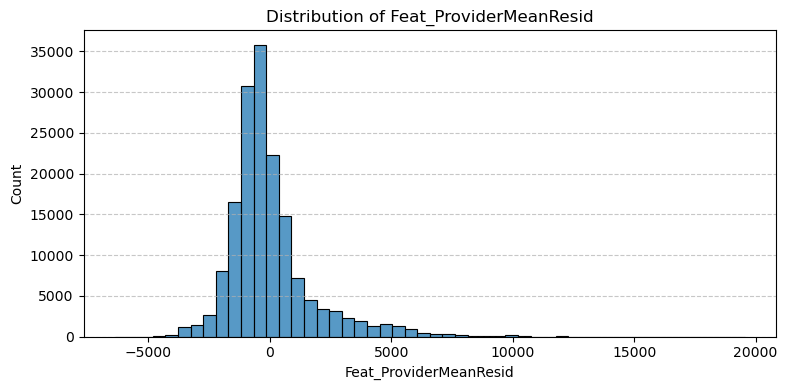

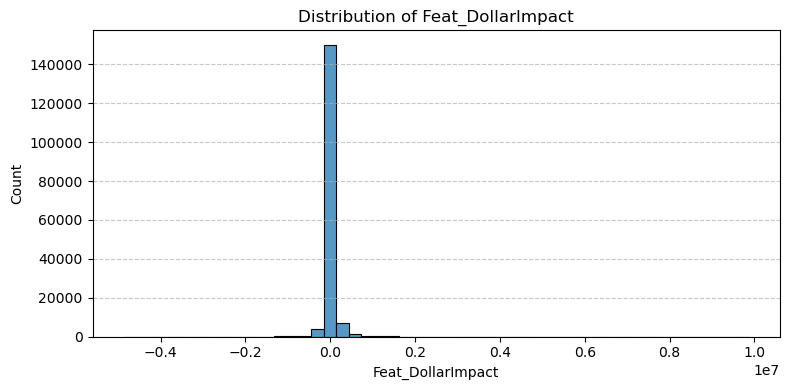

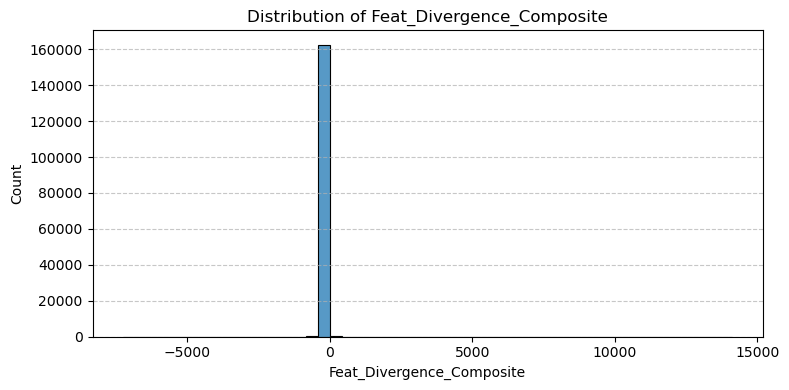

In [ ]:
# Distribution plots for each feature
for col in feature_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(data[col].dropna(), bins=50, kde=False)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

## Importing & Fitting (Ensemble) <a name="42"></a>
- A small change in hidden layers can shift which hospitals get flagged. If we only use one model, results might be unstable.

- By combining predictions from multiple Autoencoders, we:

    - Reduce dependence on any single architecture.

    - Smooth out random fluctuations.

    - Flag only the anomalies that consistently appear across models > more reliable.

- Averaging anomaly scores across models highlights providers that are consistently unusual across architectures, not just in one setup

### Single AutoEncoder Model on aggregated features

In [225]:
# This is for single AutoEncoder model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = AutoEncoder(
    hidden_neurons=[10, 5, 2, 5, 10],  # architecture
    epochs=50,
    batch_size=32,
    contamination=0.05,
    random_state=42
)
clf.fit(X_scaled)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_149 (Dense)               │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 10)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 2)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 13)             │           143 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789 (3.08 KB)

 Trainable params: 789 (3.08 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 5s 817us/step - loss: 5.0277 - val_loss: 1.4027
Epoch 2/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 808us/step - loss: 1.9468 - val_loss: 1.0149
Epoch 3/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 805us/step - loss: 1.6337 - val_loss: 0.9733
Epoch 4/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 803us/step - loss: 1.4389 - val_loss: 0.9706
Epoch 5/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 787us/step - loss: 1.3176 - val_loss: 0.9701
Epoch 6/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 795us/step - loss: 1.2202 - val_loss: 0.9707
Epoch 7/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 801us/step - loss: 1.1513 - val_loss: 0.9700
Epoch 8/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 785us/step - loss: 1.0994 - val_loss: 0.9699
Epoch 9/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 803us/step - loss: 1.0605 - val_loss: 0.9699
Epoch 10/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 770us/step - loss: 1.0375 - val_loss: 0.9699
Epoch 11/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 776us/step - loss: 1.0212 - val_loss: 0.9699
Epo

AutoEncoder(batch_size=32, contamination=0.05, dropout_rate=0.2, epochs=50,
      hidden_activation='relu', hidden_neurons=[10, 5, 2, 5, 10],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x00000200A22868E0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=42, validation_size=0.1, verbose=1)

### Ensemble AutoEncoder Model on aggregated features

In [226]:
archs = [
    [10, 5, 2, 5, 10], 
    [15, 10, 5, 10, 15], 
    [20, 15, 10, 2, 10, 15, 20]
]

scores_list = []
for arch in archs:
    clf_temp = AutoEncoder(
        hidden_neurons=arch,
        epochs=50,
        batch_size=32,
        contamination=0.05,
        random_state=42
    )
    clf_temp.fit(X_scaled)
    scores_list.append(clf_temp.decision_function(X_scaled))

scores_array = np.array(scores_list)  # shape = (n_models, n_samples)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_157 (Dense)               │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 10)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 2)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 13)             │           143 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789 (3.08 KB)

 Trainable params: 789 (3.08 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 5s 863us/step - loss: 4.8397 - val_loss: 1.2375
Epoch 2/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 785us/step - loss: 1.6691 - val_loss: 0.9589
Epoch 3/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 811us/step - loss: 1.3363 - val_loss: 0.9351
Epoch 4/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 804us/step - loss: 1.2127 - val_loss: 0.9315
Epoch 5/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 773us/step - loss: 1.1201 - val_loss: 0.9312
Epoch 6/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 783us/step - loss: 1.0716 - val_loss: 0.9311
Epoch 7/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 766us/step - loss: 1.0441 - val_loss: 0.9311
Epoch 8/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 776us/step - loss: 1.0230 - val_loss: 0.9311
Epoch 9/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 779us/step - loss: 1.0138 - val_loss: 0.9340
Epoch 10/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 778us/step - loss: 1.0100 - val_loss: 0.9311
Epoch 11/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 775us/step - loss: 1.0083 - val_loss: 0.9311
Epo

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_165 (Dense)               │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 15)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 15)             │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 13)             │           208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,222 (4.77 KB)

 Trainable params: 1,222 (4.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 5s 904us/step - loss: 4.2116 - val_loss: 3.1356
Epoch 2/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 886us/step - loss: 1.2639 - val_loss: 2.0180
Epoch 3/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 863us/step - loss: 1.0466 - val_loss: 1.7820
Epoch 4/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 867us/step - loss: 1.0133 - val_loss: 1.5406
Epoch 5/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 868us/step - loss: 1.0027 - val_loss: 1.4140
Epoch 6/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 867us/step - loss: 0.9994 - val_loss: 1.4129
Epoch 7/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 876us/step - loss: 0.9970 - val_loss: 1.4128
Epoch 8/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 865us/step - loss: 0.9968 - val_loss: 1.4128
Epoch 9/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 864us/step - loss: 0.9968 - val_loss: 1.4128
Epoch 10/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 866us/step - loss: 0.9968 - val_loss: 1.4128
Epoch 11/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 877us/step - loss: 0.9968 - val_loss: 1.4128
Epo

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_173 (Dense)               │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 20)             │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 2)              │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 15)             │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 20)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 13)             │           273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,929 (7.54 KB)

 Trainable params: 1,929 (7.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 6s 915us/step - loss: 4.1079 - val_loss: 1.1994
Epoch 2/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step - loss: 1.2934 - val_loss: 0.9374
Epoch 3/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 877us/step - loss: 1.0975 - val_loss: 0.9153
Epoch 4/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 889us/step - loss: 1.0499 - val_loss: 0.9134
Epoch 5/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 880us/step - loss: 1.0285 - val_loss: 0.9133
Epoch 6/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 883us/step - loss: 1.0207 - val_loss: 0.9132
Epoch 7/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 881us/step - loss: 1.0134 - val_loss: 0.9133
Epoch 8/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 4s 884us/step - loss: 1.0108 - val_loss: 0.9132
Epoch 9/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.0097 - val_loss: 0.9132
Epoch 10/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.0096 - val_loss: 0.9132
Epoch 11/50
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.0096 - val_loss: 0.9132
Epoch 12/

## Prediction & Scores <a name="43"></a>

In [232]:
# Single AutoEncoder results
labels = clf.labels_            # 0 = normal, 1 = anomaly
scores = clf.decision_scores_   # anomaly scores


data_with_results = data.copy()
data_with_results["Anomaly_Label"] = labels
data_with_results["Anomaly_Score"] = scores


summary = (data_with_results
           .groupby("Anomaly_Label")[feature_cols + ["Anomaly_Score"]]
           .mean()
           .reset_index())

# Add counts
counts = data_with_results["Anomaly_Label"].value_counts().reset_index()
counts.columns = ["Anomaly_Label", "Count"]
counts["Count %"] = 100 * counts["Count"] / len(data_with_results)

# Merge
summary = summary.merge(counts, on="Anomaly_Label")

# Map labels
summary["Group"] = summary["Anomaly_Label"].map({0: "Normal", 1: "Outlier"})
summary = summary.drop(columns=["Anomaly_Label"])

# Reorder
cols = ["Group", "Count", "Count %"] + [c for c in summary.columns if c not in ["Group", "Count", "Count %"]]
summary = summary[cols]

# Show result
print(summary.to_string(index=False))


# Ensemble AutoEncoder results
avg_scores = np.mean(scores_array, axis=0)
max_scores = np.max(scores_array, axis=0)


contamination = 0.05
n_samples = X_scaled.shape[0]
n_outliers = int(contamination * n_samples)

def get_labels(scores):
    thresh = np.sort(scores)[-n_outliers]
    labels = (scores >= thresh).astype(int)
    return labels, thresh

labels_single, _ = get_labels(scores_list[0])
labels_avg, _    = get_labels(avg_scores)
labels_max, _    = get_labels(max_scores)


results = {}
for name, labels, scores in [
    ("Single AutoEncoder", labels_single, scores_list[0]),
    ("Ensemble (Average)", labels_avg, avg_scores),
    ("Ensemble (Max)", labels_max, max_scores)
]:
    df_temp = data.copy()
    df_temp["Anomaly_Label"] = labels
    df_temp["Anomaly_Score"] = scores

    summary = (df_temp
               .groupby("Anomaly_Label")[feature_cols + ["Anomaly_Score"]]
               .mean()
               .reset_index())

    counts = df_temp["Anomaly_Label"].value_counts().reset_index()
    counts.columns = ["Anomaly_Label", "Count"]
    counts["Count %"] = 100 * counts["Count"] / len(df_temp)

    summary = summary.merge(counts, on="Anomaly_Label")
    summary["Group"] = summary["Anomaly_Label"].map({0: "Normal", 1: "Outlier"})
    summary["Model"] = name
    results[name] = summary.drop(columns=["Anomaly_Label"])

# Nicely formatted combined results
pd.set_option("display.max_columns", None)   
pd.set_option("display.width", 150)       


cols = ["Model", "Group", "Count", "Count %"] + \
       [c for c in final_summary.columns if c not in ["Model","Group","Count","Count %"]]
final_summary = final_summary[cols]



# Display as table
from IPython.display import display
display(final_summary)



  Group  Count  Count %  Feat_Ratio_StateDRG  Feat_Deviation_StateDRG  RZ_Average_Total_Payments_by_Provider_State_DRG  PctRank_Average_Total_Payments_by_Provider_State_DRG  Feat_Spend_Leverage  Feat_MedicareShare  Feat_Markup  Feat_PaymentShare_StateDRG  Feat_CaseMix_Adjusted_Index  IQRScore_Average_Total_Payments_by_DRG  Feat_ProviderMeanResid  Feat_DollarImpact  Feat_Divergence_Composite  Anomaly_Score
 Normal 154911 94.99954             0.976997              -280.549326                                         0.216300                                              0.496437         31101.455331            0.845020     3.809637                    0.026849                     1.048868                               -0.470072             -206.472486       -7833.627060                   0.314348       2.523797
Outlier   8154  5.00046             1.437022              5329.921102                                         3.549251                                              0.875815         7

,Model,Group,Count,Count %,Feat_Ratio_StateDRG,Feat_Deviation_StateDRG,RZ_Average_Total_Payments_by_Provider_State_DRG,PctRank_Average_Total_Payments_by_Provider_State_DRG,Feat_Spend_Leverage,Feat_MedicareShare,Feat_Markup,Feat_PaymentShare_StateDRG,Feat_CaseMix_Adjusted_Index,IQRScore_Average_Total_Payments_by_DRG,Feat_ProviderMeanResid,Feat_DollarImpact,Feat_Divergence_Composite,Anomaly_Score
0,Single AutoEncoder,Normal,154912,95.0,0.977,-280.597,0.216,0.496,31101.515,0.845,3.810,0.027,1.049,-0.470,-206.512,-7835.223,0.314,2.524
1,Single AutoEncoder,Outlier,8153,5.0,1.437,5331.523,3.550,0.876,76331.606,0.876,3.101,0.106,1.626,1.993,3923.859,228193.765,-14.588,9.204
2,Ensemble (Average),Normal,154912,95.0,0.977,-280.534,0.216,0.496,31101.410,0.845,3.810,0.027,1.049,-0.470,-206.454,-7832.720,0.314,2.524
3,Ensemble (Average),Outlier,8153,5.0,1.437,5330.324,3.549,0.876,76333.602,0.876,3.102,0.106,1.626,1.993,3922.751,228146.206,-14.588,9.204
4,Ensemble (Max),Normal,154912,95.0,0.977,-280.534,0.216,0.496,31101.410,0.845,3.810,0.027,1.049,-0.470,-206.454,-7832.720,0.314,2.524
5,Ensemble (Max),Outlier,8153,5.0,1.437,5330.324,3.549,0.876,76333.602,0.876,3.102,0.106,1.626,1.993,3922.751,228146.206,-14.588,9.204


- All three methods flagged the same proportion (5%) of anomalies, with extremely close averages for engineered features.

- Outliers differ strongly from normals in:

    - Feat_Ratio_StateDRG: Outliers ~1.44 vs Normals ~0.98

    - Feat_Deviation_StateDRG: Outliers +5,300 vs Normals −280

    - Feat_DollarImpact: Outliers +228k vs Normals −7,800

- Even though the numerical results look almost identical, using an ensemble reduces the chance of false positives that may come from depending on a single AutoEncoder architecture.

# What's Next? <a name="4"></a>
- If we later receive a new CSV with fresh hospital billing data, we don’t retrain right away.

- We would perform the same preprocessing steps (cleaning, scaling) as before.

- Then, we would use the already trained AutoEncoder model to predict anomaly scores on the new data.

- This way, we leverage the learned patterns from the original training without needing to retrain the model each time.